In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import timedelta

In [2]:
#Загрузка файлов
df_customers   = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/FUi5uSd6BfG_ig')
df_orders      = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/t9Li4JOfgxuUrg')
df_order_items = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw')

In [3]:
#Проверка на наличие пропущенных значений
df_customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [4]:
df_orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [5]:
df_order_items.isnull().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [6]:
#Проверка размера таблиц
df_customers.shape

(99441, 5)

In [7]:
df_orders.shape

(99441, 8)

In [8]:
df_order_items.shape

(112650, 7)

In [9]:
#Конвертируем таймстэмп в дату
df_orders.order_purchase_timestamp=pd.to_datetime(df_orders.order_purchase_timestamp)
df_orders.order_delivered_customer_date=pd.to_datetime(df_orders.order_delivered_customer_date)
df_orders.order_approved_at=pd.to_datetime(df_orders.order_approved_at)
df_orders.order_estimated_delivery_date=pd.to_datetime(df_orders.order_estimated_delivery_date)

# 1. Сколько у нас пользователей, которые совершили покупку только один раз?

In [10]:
#Объединение таблиц покупателей и заказов
df_customers_and_orders = df_customers.merge(df_orders, on='customer_id')

In [11]:
df_customers_and_orders.shape

(99441, 12)

Изначально предположим, что к покупкам относятся все оплаченные заказы, то есть order_approved_at не равно NaN

In [12]:
#Возможные статусы заказов:
df_customers_and_orders.order_status.unique()

array(['delivered', 'canceled', 'invoiced', 'shipped', 'processing',
       'unavailable', 'approved', 'created'], dtype=object)

In [13]:
#Проверка существуют ли заказы с несколькими статусами, для каждого заказа -  1 статус 
#это значит, что здесь представлен последний имеющийся статус заказа
df_customers_and_orders\
    .groupby('order_id')\
    .agg({'order_status' : 'count'})\
    .sort_values(by=['order_status'])

,order_status
order_id,
00010242fe8c5a6d1ba2dd792cb16214,1
ab30f399d360ddf62897051d813f887d,1
ab30819331b8ee6115370bcfa01a8350,1
ab3049853be314c3dcc3721cea4438e1,1
ab2fa8175483622f44ca36cf7f9198b2,1
...,...
55534471fcbe2dd1436234e7cfa4de5a,1
55531bd6b11adf2791aeca35f0305e65,1
55529dc7cb99d0befad66b19ad9adc8d,1


In [14]:
#Посмотрим на разбивку заказов в зависимости от статуса
df_customers_and_orders['order_approved']=df_customers_and_orders.order_approved_at.notna()
df_customers_and_orders\
    .query("order_approved == True ")\
    .groupby('order_status')\
    .agg({'order_id':'count'})\
    .sort_values(by='order_id', ascending=False)

,order_id
order_status,
delivered,96464
shipped,1107
unavailable,609
canceled,484
invoiced,314
processing,301
approved,2


здесь можно увидеть, что оплаченных заказов в статусе 'created' нет, что не противоречит логике
так же есть только 2 оплаченных заказа до выставления счета, что тоже впринципе адекватно

In [15]:
#так как есть статус заказа 'canceled', посморим на него подробнее
df_customers_and_orders.query("order_status == 'canceled' ").groupby('order_delivered_customer_date').agg({'order_id':'count'}) 

,order_id
order_delivered_customer_date,
2016-10-14 15:07:11,1
2016-10-16 14:36:59,1
2016-10-19 18:47:43,1
2016-11-08 10:58:34,1
2016-11-09 14:53:50,1
2018-03-21 22:03:51,1


по 6 отмененным закзазам время достаки не равно NaN, можно сделать предположение, что заказ может быть отменен и после доставки
это значит, что считать покупкой оплаченные заказы, у которых проставлена order_delivered_customer_date нельзя 

In [16]:
#также посмотрим на статус заказа 'unavailable'
df_unavailable=df_customers_and_orders.query("order_status == 'unavailable'") 
df_unavailable.shape

(609, 13)

In [17]:
df_unavailable.isna().sum()

customer_id                        0
customer_unique_id                 0
customer_zip_code_prefix           0
customer_city                      0
customer_state                     0
order_id                           0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date     609
order_delivered_customer_date    609
order_estimated_delivery_date      0
order_approved                     0
dtype: int64

так как ни по одному заказу со статусом 'unavailable' нет информации о дате передачи заказа в логистическую службу
и дате отгрузки, считаю, лучше эти заказы из покупок исключить, так как вряд ли по ним будут какие-то изменения
таким образом, покупкой будем считать оплаченные заказы, у которых статус заказа не равен 'canceled' или 'unavailable'

In [18]:
df_customers_and_orders\
    .query("order_approved == True and order_status != 'canceled' and order_status != 'unavailable'")\
    .groupby ('customer_unique_id')\
    .agg({'order_id':'count'})\
    .rename(columns={"order_id":"order_count"})\
    .query("order_count==1")\
    .count()

order_count    92087
dtype: int64

ответ задание_1: пользователей, совершивших только 1 покупку - 92 087 

# 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [19]:
#для определения месяца доставки заказа используем обещанную дату заказа
#так как это месяц, в котором доставкка должна была быть осуществлена, и в этой колонке нет пропущенных значений
#извлечем месяц из даты
df_orders['delivery_month']=df_orders.order_estimated_delivery_date.dt.to_period("M")

In [20]:
#к заказам, по которым не была осуществлена доставка отнесем заказы, по которым отсутсвует время доставки заказа
df_orders['order_delivered']=df_orders.order_delivered_customer_date.isna()

In [21]:
#посмотрим на статусы таких заказов
df_orders\
    .query("order_delivered == True")\
    .groupby('order_status')\
    .agg({'order_id':'count'}) 

,order_id
order_status,
approved,2
canceled,619
created,5
delivered,8
invoiced,314
processing,301
shipped,1107
unavailable,609


отсюда можно выделить 3 основные причины, почему заказ не был доставлен:

-заказ еще в процессе обработки

-заказ отменен либо его статус неизвестен

-заказ в статусе "отгружен со склада" слишком давно и нет времени его доставки

что касается 8 заказов в статусе "доставлен пользователю", эо больше похоже на ошибку, эти заказы вычтем из недоставленных

рассчитаем среднемесячное значение для каждой из причин

In [22]:
#заказ еще в процессе обработки либо доставки
var_1 = df_orders\
    .query("(order_status == 'approved' or order_status == 'created' or order_status == 'invoiced' or order_status == 'processing') and order_delivered == True ")\
    .groupby('delivery_month')\
    .agg({'order_id':'count'})
var_1_sum=var_1.sum()
var_1.mean().round(2)

order_id    29.62
dtype: float64

In [23]:
#заказ отменен либо его статус неизвестен
var_2 = df_orders\
    .query("(order_status == 'canceled' or order_status == 'unavailable') and order_delivered == True ")\
    .groupby('delivery_month')\
    .agg({'order_id':'count'})
var_2_sum=var_2.sum()
var_2.mean().round(2)

order_id    47.23
dtype: float64

теперь подробнее посмотрим на заказы в статусе "отгружен со склада"

здесь могут быть 2 варианта, почему заказ не доставлен:

-дата предполагаемой доставки на момент выгрузки таблицы еще не наступила (таких нужно отнести к 1 выборке)

-доставка просрочена либо какая-то ошибка

чтобы понять, на какую последнюю дату у нас есть информация о доставке, будем использовать order_delivered_customer_date max

если order_estimated_delivery_date > order_delivered_customer_date max, значит дата доставки еще не наступила

если order_estimated_delivery_date <= order_delivered_customer_date max, значит дата доставки просрочена

In [24]:
delivery_date_max=df_orders.order_delivered_customer_date.max()

In [25]:
df_orders\
    .query("order_status == 'shipped' and order_delivered == True and order_delivered_carrier_date > 'delivery_date_max' ")\
    .groupby('delivery_month')\
    .agg({'order_id':'count'})

,order_id
delivery_month,


недоставленных заказов в статусе "отгружен со склада", дата доставки по которым еще не наступила, нет

значит всех относим ко 2 варианту

In [26]:
#заказ отменен либо его статус неизвестен
var_3 = df_orders\
    .query("order_status == 'shipped' and order_delivered == True ")\
    .groupby('delivery_month')\
    .agg({'order_id':'count'})
var_3_sum=var_3.sum()
var_3.mean().round(2)

order_id    48.13
dtype: float64

In [27]:
#теперь, когда рассчитали средние для каждой причины, рассчитаем средневзвешанную
((var_1.mean()*var_1_sum+var_2.mean()*var_2_sum+var_3.mean()*var_3_sum)/(var_1_sum+var_2_sum+var_3_sum)).round(2)

order_id    43.86
dtype: float64

ответ задание_2: таким образом, по разным причинам в среднем в месяц не доставляется 43.86 заказа, в том числе

29.62 из-за того, что заказ в обработке

47.23 из-за того, что заказ отменен или его статус неизвестен

48.13 из-за того, что заказ в статусе "отгружен со склада", но дата доставки отсутвует(нужно направлять запрос логистике)

# 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [28]:
df_orders.order_id.nunique()

99441

In [29]:
df_order_items.order_id.nunique()

98666

In [30]:
#объединение таблиц заказов и товаров, так как в таблице товаров уникальных значений order_id меньше, используем inner join
df_orders_and_items = df_orders.merge(df_order_items, on='order_id')

In [31]:
#количество уникальных товаров
df_orders_and_items.product_id.nunique()

32951

In [32]:
#в качестве даты покупки будем использовать дату оплаты товара, так как покупкой считаем тот заказ, который оплатили
#извлечем из даты день недели
df_orders_and_items['purchase_day']=df_orders_and_items.order_approved_at.dt.day_name()

In [33]:
#согласно методолгии, описанной выше, выбираем покупки и выбираем день недели для каждого товара, когда его покупали чаще всего
#ответ задание_3
df_orders_and_items['order_approved']=df_orders_and_items.order_approved_at.notna()
df_orders_and_items\
    .query("order_approved == True and order_status != 'canceled' and order_status != 'unavailable'")\
    .groupby (['product_id', 'purchase_day'],as_index=False)\
    .agg({'order_id':'count'})\
    .rename(columns={"order_id":"purchase_count"})\
    .drop_duplicates(subset=["product_id"], keep='first') 

,product_id,purchase_day,purchase_count
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Friday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
5,000d9be29b5207b54e86aa1b1ac54872,Tuesday,1
...,...,...,...
60785,fff6177642830a9a94a0f2cba5e476d1,Monday,1
60787,fff81cc3158d2725c0655ab9ba0f712c,Monday,1
60788,fff9553ac224cec9d15d49f5a263411f,Saturday,1
60789,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1


# 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

In [35]:
#извлечем из даты день недели
df_customers_and_orders['purchase_month']=df_customers_and_orders.order_approved_at.dt.month_name()

In [36]:
# вычисяем кол-во недель в каждом месяце
df_customers_and_orders['weeks'] = df_customers_and_orders.order_approved_at.dt.days_in_month / 7

In [37]:
customer_purchases_avg = df_customers_and_orders\
    .query("order_approved == True and order_status != 'canceled' and order_status != 'unavailable'")\
    .groupby(['customer_unique_id', 'purchase_month', 'weeks'], as_index=False)\
    .agg({'order_id':'count'})\
    .rename(columns={'order_id':'purchases'}) 

In [38]:
customer_purchases_avg['purchases_avg'] = round(customer_purchases_avg.purchases/customer_purchases_avg.weeks,2)

In [39]:
#ответ задание_4
customer_purchases_avg.sort_values(by='purchases_avg', ascending=False)

,customer_unique_id,purchase_month,weeks,purchases,purchases_avg
7229,12f5d6e1cbf93dafd9dcc19095df0b3d,January,4.428571,6,1.35
61405,a239b8e2fbce33780f1f1912e2ee5275,February,4.000000,4,1.00
23636,3e43e6105506432c953e165fb2acf44c,February,4.000000,4,1.00
68508,b4e4f24de1e8725b74e4a1f4975116ed,February,4.000000,4,1.00
14305,25a560b9a6006157838aab1bdbd68624,April,4.285714,4,0.93
...,...,...,...,...,...
33855,59299ea0e75eec7b97507e1dc6ac13d1,January,4.428571,1,0.23
33854,59293545b02da9dd4e3e704c7e73f0d6,November,4.285714,1,0.23
33853,592891bfd137d0161b5209a387a4e9cb,March,4.428571,1,0.23
33852,5928064347952cf183a6d7ebc709f5b5,October,4.428571,1,0.23


In [40]:
#проверим, все ли пользователи, которые совершали покупки, учтены
df_customers_and_orders\
    .query("order_approved == True and order_status != 'canceled' and order_status != 'unavailable'")\
    .customer_unique_id.nunique() == customer_purchases_avg.customer_unique_id.nunique() 

True

# 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

In [41]:
#сначала отберем только покупки
df_purchases=df_customers_and_orders\
    .query("order_approved == True and order_status != 'canceled' and order_status != 'unavailable'")

In [42]:
#создадим колонку с годом и месяцем покупки и отсортируем данные по ней
df_purchases['year_month']=df_purchases.order_approved_at.dt.to_period('M')
df_purchases = df_purchases.sort_values(by='year_month')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [43]:
#оставим только нужные колонки
df_purchases = df_purchases[['customer_unique_id','order_id','year_month']]

In [44]:
#создадим таблицу с датой первой покупки
df_first_purchases = df_purchases\
    .groupby('customer_unique_id',as_index=False)\
    .agg({'year_month':'first'})\
    .rename(columns={'year_month':'first_purchase_month'})
df_first_purchases.head()

,customer_unique_id,first_purchase_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05
2,0000f46a3911fa3c0805444483337064,2017-03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10
4,0004aac84e0df4da2b147fca70cf8255,2017-11


In [45]:
#объединим 2 датасета
df_purchases_2 = df_purchases.merge(df_first_purchases, on = 'customer_unique_id')

In [46]:
df_purchases_2 = df_purchases_2\
    .groupby(['first_purchase_month','year_month'])\
    .agg({'customer_unique_id':'count'})

In [47]:
#функция, которая считает когорту
def cohort_period(df):
    df['cohort_period'] = np.arange(len(df)) + 1 # отсчет с 1 return df
    return df

df_purchases_2 = df_purchases_2.groupby(level=0).apply(cohort_period)
df_purchases_2.head()

customer_unique_id  cohort_period
first_purchase_month year_month                                   
2016-09              2016-09                      1              1
2016-10              2016-10                    294              1
                     2017-04                      1              2
                     2017-07                      1              3
                     2017-09                      1              4

In [48]:
#конвертируем датафрэйм в сводную таблицу
df_purchases_pivot = df_purchases_2.pivot_table(columns='cohort_period', index = 'first_purchase_month',values='customer_unique_id')
df_purchases_pivot.head()

cohort_period,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
first_purchase_month,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,294.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,749.0,4.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,2.0,2.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0
2017-02,1699.0,4.0,4.0,3.0,7.0,2.0,4.0,3.0,1.0,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,5.0


In [49]:
#посмотрим доли возврата от первоначального размера когорты
base = df_purchases_pivot[1]
retention = df_purchases_pivot.divide(base, axis=0).round(4)

In [50]:
#определим когорту с самым высоким retention на 3й месяц
retention[retention[3] == retention[3].max()].index

PeriodIndex(['2017-05'], dtype='period[M]', name='first_purchase_month', freq='M')

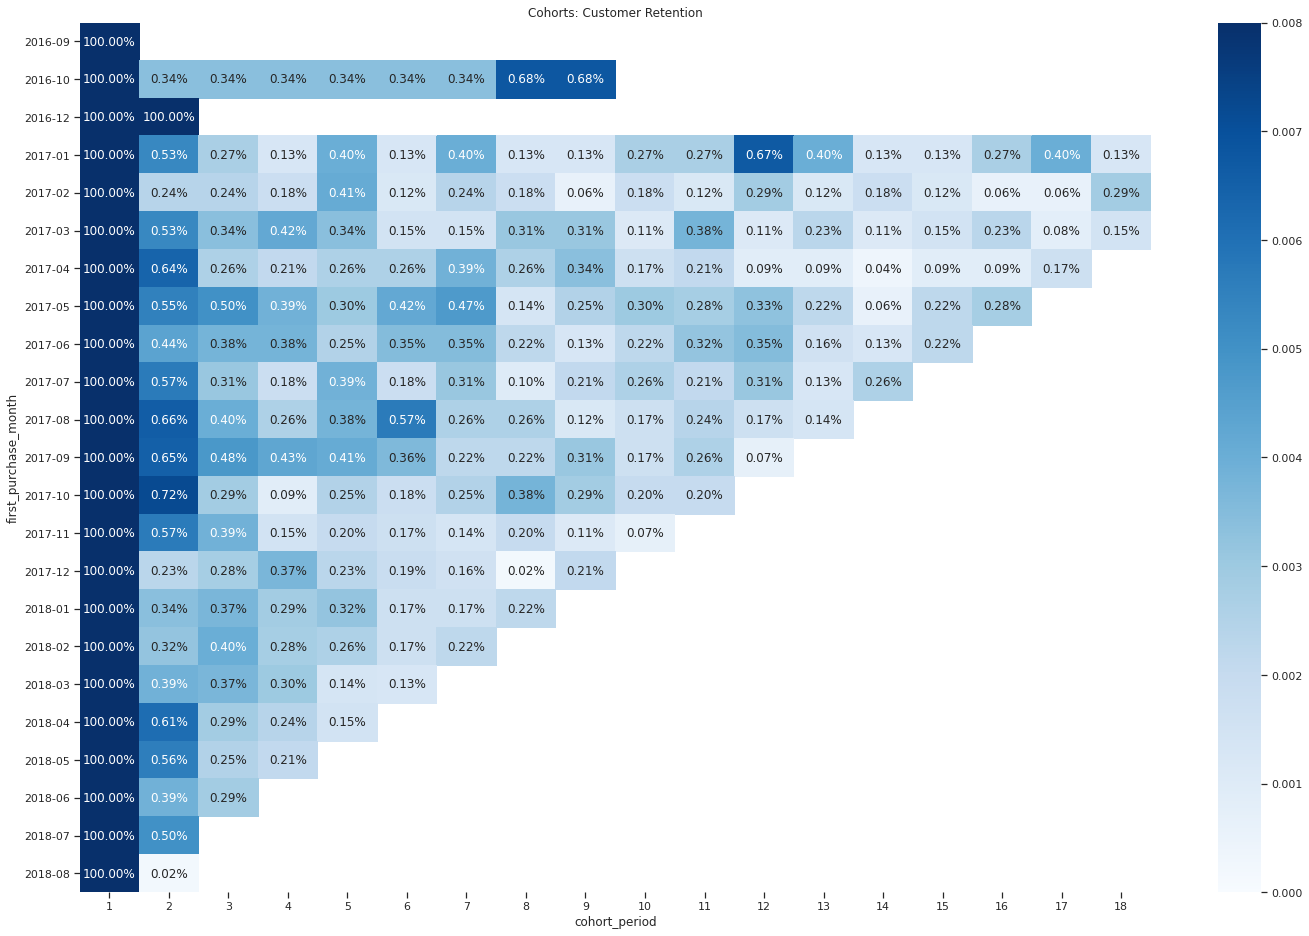

In [51]:
#визуализируем когорты
plt.rcParams['font.size'] = '11'
sns.set(style='ticks')
plt.figure(figsize=(24, 16))
plt.title('Cohorts: Customer Retention')
sns.heatmap(data=retention, annot=True, vmin=0.0,vmax=0.008, fmt='.2%',cmap='Blues' )

ответ задание_5 у когорты мая 2017 годасамый высокий retention на 3й месяц

# 6.  Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.

In [52]:
#объеденим все датафреймы
df_all=df_customers_and_orders.merge(df_order_items, on = 'order_id')

In [53]:
#отберем только покупки
df_all_purchases = df_all\
    .query("order_approved == True and order_status != 'canceled' and order_status != 'unavailable'")

In [54]:
#удалим все пропуски
df_all_purchases = df_all_purchases.dropna()

In [55]:
#оставим только нужные колонки
df_all_purchases = df_all_purchases[['customer_unique_id','order_id','order_approved_at','price']]
df_all_purchases.head()

,customer_unique_id,order_id,order_approved_at,price
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12,124.99
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:58:32,289.00
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-20 16:19:10,139.94
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 17:29:19,149.94
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 10:10:09,230.00


In [56]:
#переведем дату в нужный формат
df_all_purchases.order_approved_at = pd.to_datetime(df_all_purchases.order_approved_at)

In [57]:
#за текущую дату примем последнюю order_approved_at + 1 день, 
#так как неизвестно, когда формировалась выгрузка, но вероятно на следующий день от последней покупки
#рассчитаем разницу между текущей датой и датой покупки
now = df_all_purchases.order_approved_at.max() + timedelta(days=1)
df_all_purchases['time_delta'] = df_all_purchases.order_approved_at.apply(lambda x: (now - x).days)
df_all_purchases.head()

,customer_unique_id,order_id,order_approved_at,price,time_delta
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12,124.99,470
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:58:32,289.00,229
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-20 16:19:10,139.94,101
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 17:29:19,149.94,169
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 10:10:09,230.00,32


In [58]:
#cоздадим таблицу RFM
#R - время от последней покупки пользователя до текущей даты 
#F - суммарное количество покупок у пользователя за всё время 
#M - стоимость покупок за всё время
#time_delta будем брать минимальное, чтобы учитывать время от последней покупки
RFM = df_all_purchases\
    .groupby('customer_unique_id')\
    .agg({'time_delta': lambda x: x.min(), 'order_id':lambda x: len(x), 'price':lambda x: x.sum()})\
    .rename(columns={'time_delta': 'R', 'order_id': 'F', 'price': 'M'})

определим границы интервалов:

In [59]:
#по предыдущему анализу данных помним, что большинство покупателей совершало 1 покупку, убедимся в этом
RFM.F.value_counts(normalize=True).mul(100)

1     87.563212
2      9.422945
3      1.763521
4      0.665338
5      0.258207
6      0.203566
7      0.048213
8      0.017142
10     0.011785
11     0.011785
9      0.010714
12     0.009643
14     0.003214
15     0.003214
13     0.002143
20     0.002143
21     0.001071
18     0.001071
24     0.001071
Name: F, dtype: float64

так как действительно больше 87% покупателей совершило 1 покупку, считаю целесообразным выделить 3 следующих сегмента:

1 покупка

2-3 покупки

больше 4 покупок

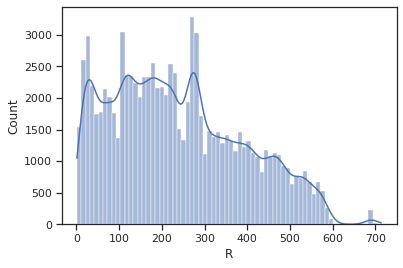

In [60]:
#посмотрим на распределение recency
sns.histplot(data=RFM, x='R', kde=True)

здесь мы можем увидеть, что после 300 дней количество покупателей начинает снижаться, но не зная специфики бизнеса, сложно определить, до какого количества дней можно считать, что покупки совершаются часто
поэтому установим следующие границы интервалов:

до 150 дней

от 151 до 300 дней

больше 300 дней

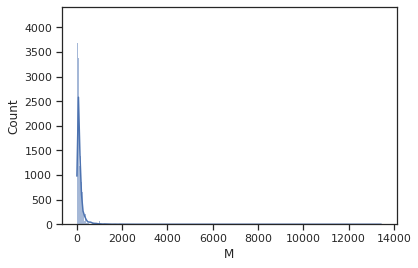

In [61]:
#посмотрим на распределение monetary
sns.histplot(data=RFM, x='M', kde=True)

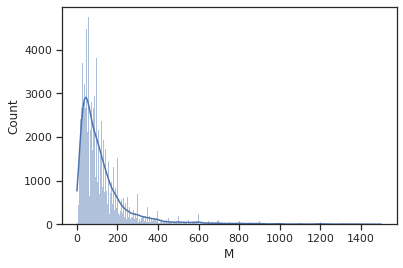

In [62]:
#так как много выбросов, попробуем их срезать и посмотреть на распределение
RFM_2 = RFM.query('M<1500')
sns.histplot(data=RFM_2, x='M', kde=True)

большинство значений лежит в пределах от 0 до 200, от 200 до 400 количество покупателей резко снижается, после 400 можно сказать, что это редкие значения, поэтомы выделим 3 интервала:

-до 200

-201-400

-больше 400

In [63]:
#напишем функцию для присвоения рангов
#1-лучший,2-среднийб 3 - худший
def r_score(x):
    if x <= 150:
        return 1
    elif x <= 300:
        return 2
    else:
        return 3
    
def f_score(x):
    if x == 1:
        return 3
    elif x <=3:
        return 2
    else:
        return 1

def m_score(x):
    if x <= 200:
        return 3
    elif x <= 400:
        return 2
    else:
        return 1    
    

In [64]:
#присваевоим RFM ранги пользователям
RFM['R_rank'] = RFM['R'].apply(lambda x: r_score(x))
RFM['F_rank'] = RFM['F'].apply(lambda x: f_score(x))
RFM['M_rank'] = RFM['M'].apply(lambda x: m_score(x))
RFM['RFM_rank'] = RFM['R_rank'].map(str) + RFM['F_rank'].map(str) + RFM['M_rank'].map(str)
RFM.head()

,R,F,M,R_rank,F_rank,M_rank,RFM_rank
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,1,3,3,133
0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,1,3,3,133
0000f46a3911fa3c0805444483337064,537,1,69.00,3,3,3,333
0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,3,3,3,333
0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,3,3,233


In [65]:
#посмотрим долю каждого ранга
RFM.RFM_rank.value_counts(normalize=True).mul(100).round(2)

233    26.20
133    25.73
333    23.76
223     2.75
232     2.72
332     2.71
123     2.58
132     2.55
323     2.45
131     1.36
331     1.29
231     1.24
122     0.91
222     0.89
322     0.71
121     0.34
221     0.28
321     0.28
113     0.16
313     0.16
111     0.16
213     0.16
112     0.14
211     0.13
212     0.12
311     0.11
312     0.10
Name: RFM_rank, dtype: float64

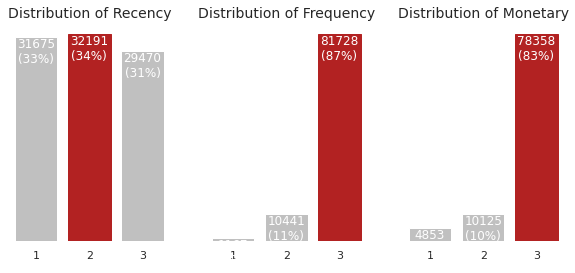

In [66]:
#визуализируем результат
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

for i, p in enumerate(['R_rank', 'F_rank', 'M_rank']):
    parameters = {'R_rank':'Recency', 'F_rank':'Frequency', 'M_rank':'Monetary'}
    y = RFM[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

Выводы задание_6:
Данный RFM-анализ делит клиентскую базу на 9 сегментов в зависимости от частоты их покупок и их давности.

По давности заказа (Recency):

1 — недавние клиенты;2 — относительно недавние клиенты;3 — давние клиенты

По частоте покупок (Frequency):

1 — покупают часто;2 — покупают нечасто;3 — единичные покупки

По сумме покупок (Monetary):

1 — большая сумма;2 — средняя сумма;3 — маленькая сумма

111	- это "чемпионы", стратегически важные клиенты, они регулярно совершают покупки и пользуются услугами.

*1*	- это "лояльные" клиенты, которые тратят небольшие деньги, но при этом регулярно делают покупки.

**1 - это клиенты, которые взаимодействуют с компанией нерегулярно, но при этом тратят большие суммы.

33* - это уходящие клинты.

333	- это "потерянные" клиенты, которые давно не взаимодействуют с компанией.

Основная доля наших клиентов (более 51%) - это клиенты, которые совершили 1 недорогую покупку относительно недавно (до 300 дней), следующая по величине категория (более 23%) - это "потерянные" клиенты. То есть у наших покупателей низкий средний чек, да и можно сказать, что низкий retention. "Чемпионы" в нашей базе составляют всего 0,16%
